# Overview

Create boundaries of United Hospital Fund Boundaries by dissolving census blocks into larger entities. Main processing steps include a table join and dissolving the census blocks into larger entities, and reclassify data to answer how many people are served in each health district.

```
├── GEOG485
│   ├── Code
│   │   ├── this notebook
│   ├── Data
│   │   ├── nyc_shapefiles
│   │   │   ├── UHF_42_DOHMH_2009.shp
│   │   │   ├── nyc_census_blocks.shp

```

*(`UHF_42_DOHMH_2009.shp`: United Hospital Fund Boundaries, Forty-two New York City Neighborhoods. Downloaded from [here](https://www1.nyc.gov/site/doh/data/data-sets/maps-gis-data-files-for-download.page))*


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/GEOG485/Code/') # change this to your folder if needed

In [ ]:
! pip install geopandas
! pip install rtree
! pip install -U mapclassify

## Problem 1: How many people does each health care district serve?

**Steps:**
1. Read in the two shapefiles, check how many features there are in the two layers, make sure they are in the same crs, and plot them (for health district layer, plot using `column='UHF_NEIGH'`)
2. Remove N/A rows in the hospital districts layer, and check length again
3. Merge health district info to nyc_census_blocks layer, so that each census block matches with a health district *(tip: use sjoin() function)*
4. Check the count of census blocks per health care disctrict
5. Dissolve (=combine) census block polygon geometries for each health care district
6. Create a plot that shows how many total population each health care district serves (choropleth map: plot using two different classification schemes)
7. Write health districts data into a GeoJSON

In [ ]:
# Step 1: read in two shapefiles
import geopandas as gpd

nyc_census_blocks = gpd.read_file('/content/drive/MyDrive/GEOG485/Data/nyc_shapefiles/nyc_census_blocks.shp')
hospital_districts = gpd.read_file('/content/drive/MyDrive/GEOG485/Data/nyc_shapefiles/UHF_42_DOHMH_2009.shp')

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

In [ ]:
nyc_census_blocks.head()

,BLKID,POPN_TOTAL,POPN_WHITE,POPN_BLACK,POPN_NATIV,POPN_ASIAN,POPN_OTHER,BORONAME,geometry
0,360850009001000,97,51,32,1,5,8,Staten Island,"POLYGON ((577856.547 4499583.235, 577862.635 4..."
1,360850020011000,66,52,2,0,7,5,Staten Island,"POLYGON ((578620.717 4495974.818, 578535.358 4..."
2,360850040001000,62,14,18,2,25,3,Staten Island,"POLYGON ((577227.224 4495995.067, 577155.625 4..."
3,360850074001000,137,92,12,0,13,20,Staten Island,"POLYGON ((579037.033 4494421.770, 579000.015 4..."
4,360850096011000,289,230,0,0,32,27,Staten Island,"POLYGON ((577652.483 4494975.052, 577681.914 4..."


In [ ]:
hospital_districts.head()

,OBJECTID,UHFCODE,SHAPE_Leng,SHAPE_Area,UHF_NEIGH,BOROUGH,geometry
0,1,0.0,207587.595627,2.764099e+08,None,N/A,"MULTIPOLYGON (((1052698.331 161778.389, 105230..."
1,2,101.0,57699.154353,1.332914e+08,Kingsbridge - Riverdale,Bronx,"POLYGON ((1017992.893 269222.964, 1017812.000 ..."
2,3,102.0,88219.319109,1.813708e+08,Northeast Bronx,Bronx,"POLYGON ((1025012.990 270794.260, 1025061.481 ..."
3,4,103.0,59711.871991,1.407724e+08,Fordham - Bronx Park,Bronx,"POLYGON ((1023994.480 261065.967, 1023885.806 ..."
4,5,104.0,250903.372273,3.865737e+08,Pelham - Throgs Neck,Bronx,"MULTIPOLYGON (((1017075.039 237316.182, 101707..."


In [ ]:
# check how many features there are in the two layers
print(nyc_census_blocks.shape[0])
print(hospital_districts.shape[0])

38794
43


In [ ]:
# make sure they are in the same crs (epsg:26918)
nyc_census_blocks.crs

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

<Projected CRS: EPSG:26918>
Name: NAD83 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 78°W and 72°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Connecticut; Delaware; Maryland; Massachusetts; New Hampshire; New Jersey; New York; North Carolina; Pennsylvania; Virginia; Vermont.
- bounds: (-78.0, 28.28, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
#check hospital data
hospital_districts.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
#convert hospital crs
hospital_districts = hospital_districts.to_crs('epsg:26918')

In [ ]:
#check crs to make sure it's changed
hospital_districts.crs
#worked!

<Projected CRS: EPSG:26918>
Name: NAD83 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 78°W and 72°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Connecticut; Delaware; Maryland; Massachusetts; New Hampshire; New Jersey; New York; North Carolina; Pennsylvania; Virginia; Vermont.
- bounds: (-78.0, 28.28, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

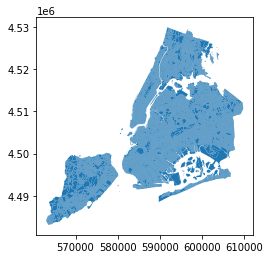

In [ ]:
# Plot nyc_census_blocks 
nyc_census_blocks.plot()
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

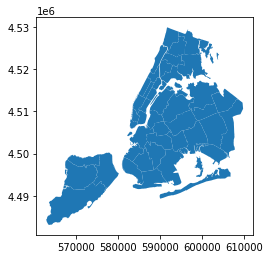

In [ ]:
# Plot hospital_districts 
hospital_districts.plot()
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

In [ ]:
# Step 2: Remove the row with N/A information
#check NA values for both the df
print(nyc_census_blocks.isna().sum())
print(hospital_districts.isna().sum())

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

BLKID         0
POPN_TOTAL    0
POPN_WHITE    0
POPN_BLACK    0
POPN_NATIV    0
POPN_ASIAN    0
POPN_OTHER    0
BORONAME      0
geometry      0
dtype: int64
OBJECTID      0
UHFCODE       0
SHAPE_Leng    0
SHAPE_Area    0
UHF_NEIGH     1
BOROUGH       0
geometry      0
dtype: int64


In [ ]:
#drop the na row
hospital_districts = hospital_districts.dropna()

In [ ]:
# Check number of rows again
len(hospital_districts)

42

In [ ]:
# Step 3: Merge health district info to geodata 
join=gpd.sjoin(nyc_census_blocks,hospital_districts, how='inner', predicate='within')
# Merge health district info to nyc_census_blocks layer, so that each census block matches with a health district (tip: use sjoin() function)
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

In [ ]:
join.head()

,BLKID,POPN_TOTAL,POPN_WHITE,POPN_BLACK,POPN_NATIV,POPN_ASIAN,POPN_OTHER,BORONAME,geometry,index_right,OBJECTID,UHFCODE,SHAPE_Leng,SHAPE_Area,UHF_NEIGH,BOROUGH
0,360850009001000,97,51,32,1,5,8,Staten Island,"POLYGON ((577856.547 4499583.235, 577862.635 4...",40,41,502.0,107053.88665,3.272437e+08,Stapleton - St. George,Staten Island
1,360850020011000,66,52,2,0,7,5,Staten Island,"POLYGON ((578620.717 4495974.818, 578535.358 4...",40,41,502.0,107053.88665,3.272437e+08,Stapleton - St. George,Staten Island
2,360850040001000,62,14,18,2,25,3,Staten Island,"POLYGON ((577227.224 4495995.067, 577155.625 4...",40,41,502.0,107053.88665,3.272437e+08,Stapleton - St. George,Staten Island
3,360850074001000,137,92,12,0,13,20,Staten Island,"POLYGON ((579037.033 4494421.770, 579000.015 4...",40,41,502.0,107053.88665,3.272437e+08,Stapleton - St. George,Staten Island
4,360850096011000,289,230,0,0,32,27,Staten Island,"POLYGON ((577652.483 4494975.052, 577681.914 4...",40,41,502.0,107053.88665,3.272437e+08,Stapleton - St. George,Staten Island


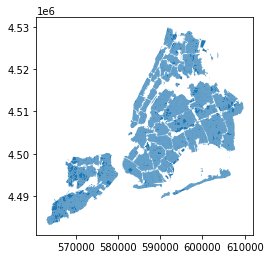

In [ ]:
join.plot()

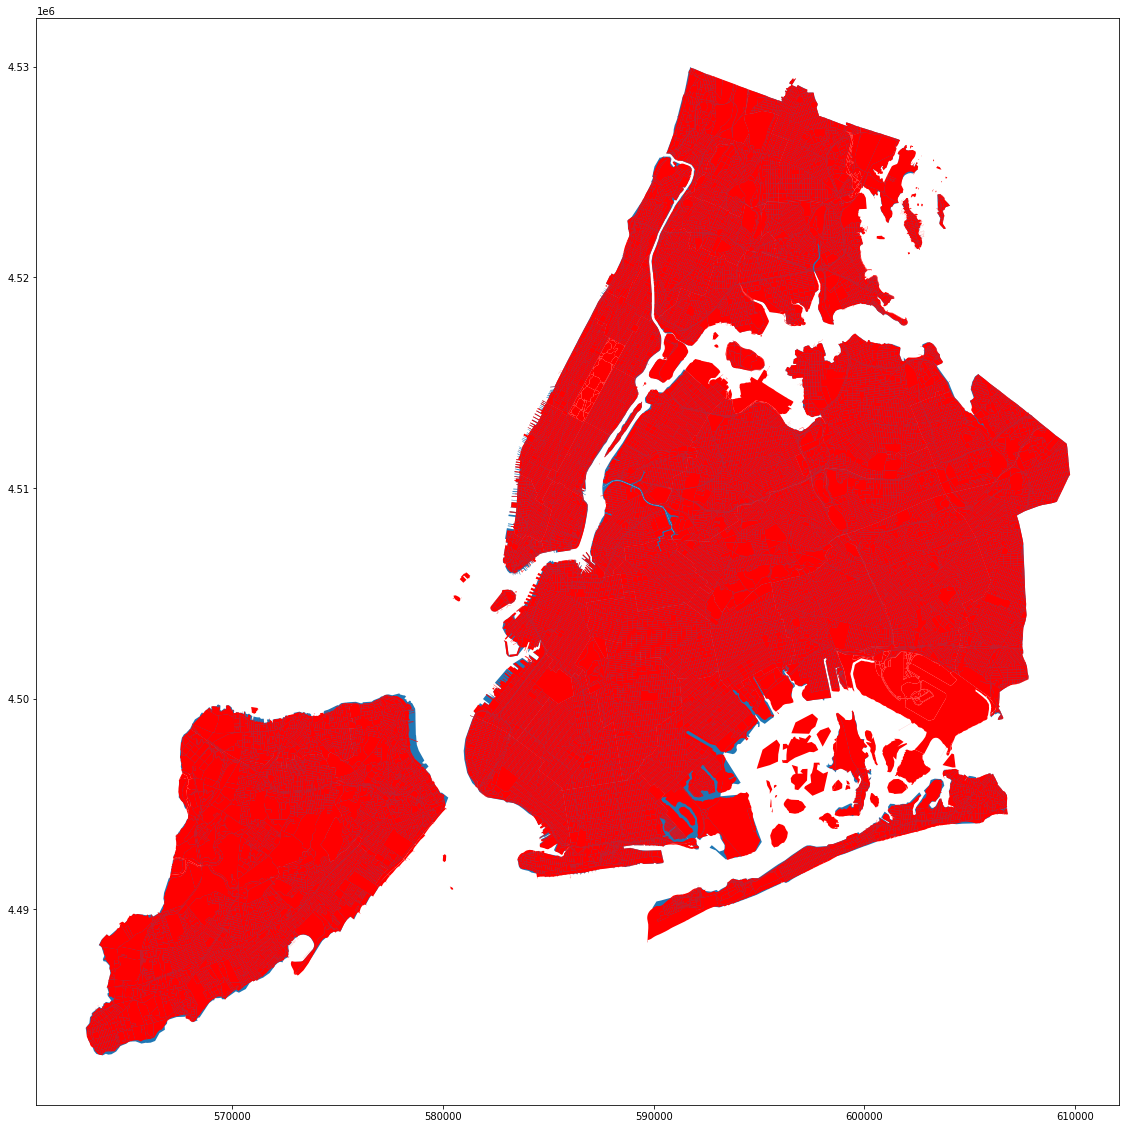

In [ ]:
#plot to check if this makes sense-->  cencus
import matplotlib.pyplot as plt

#create a figure
fig, ax = plt. subplots(figsize=(20,20))

hospital_districts.plot (ax =ax)

nyc_census_blocks.plot(ax=ax, color ='red',markersize =5)

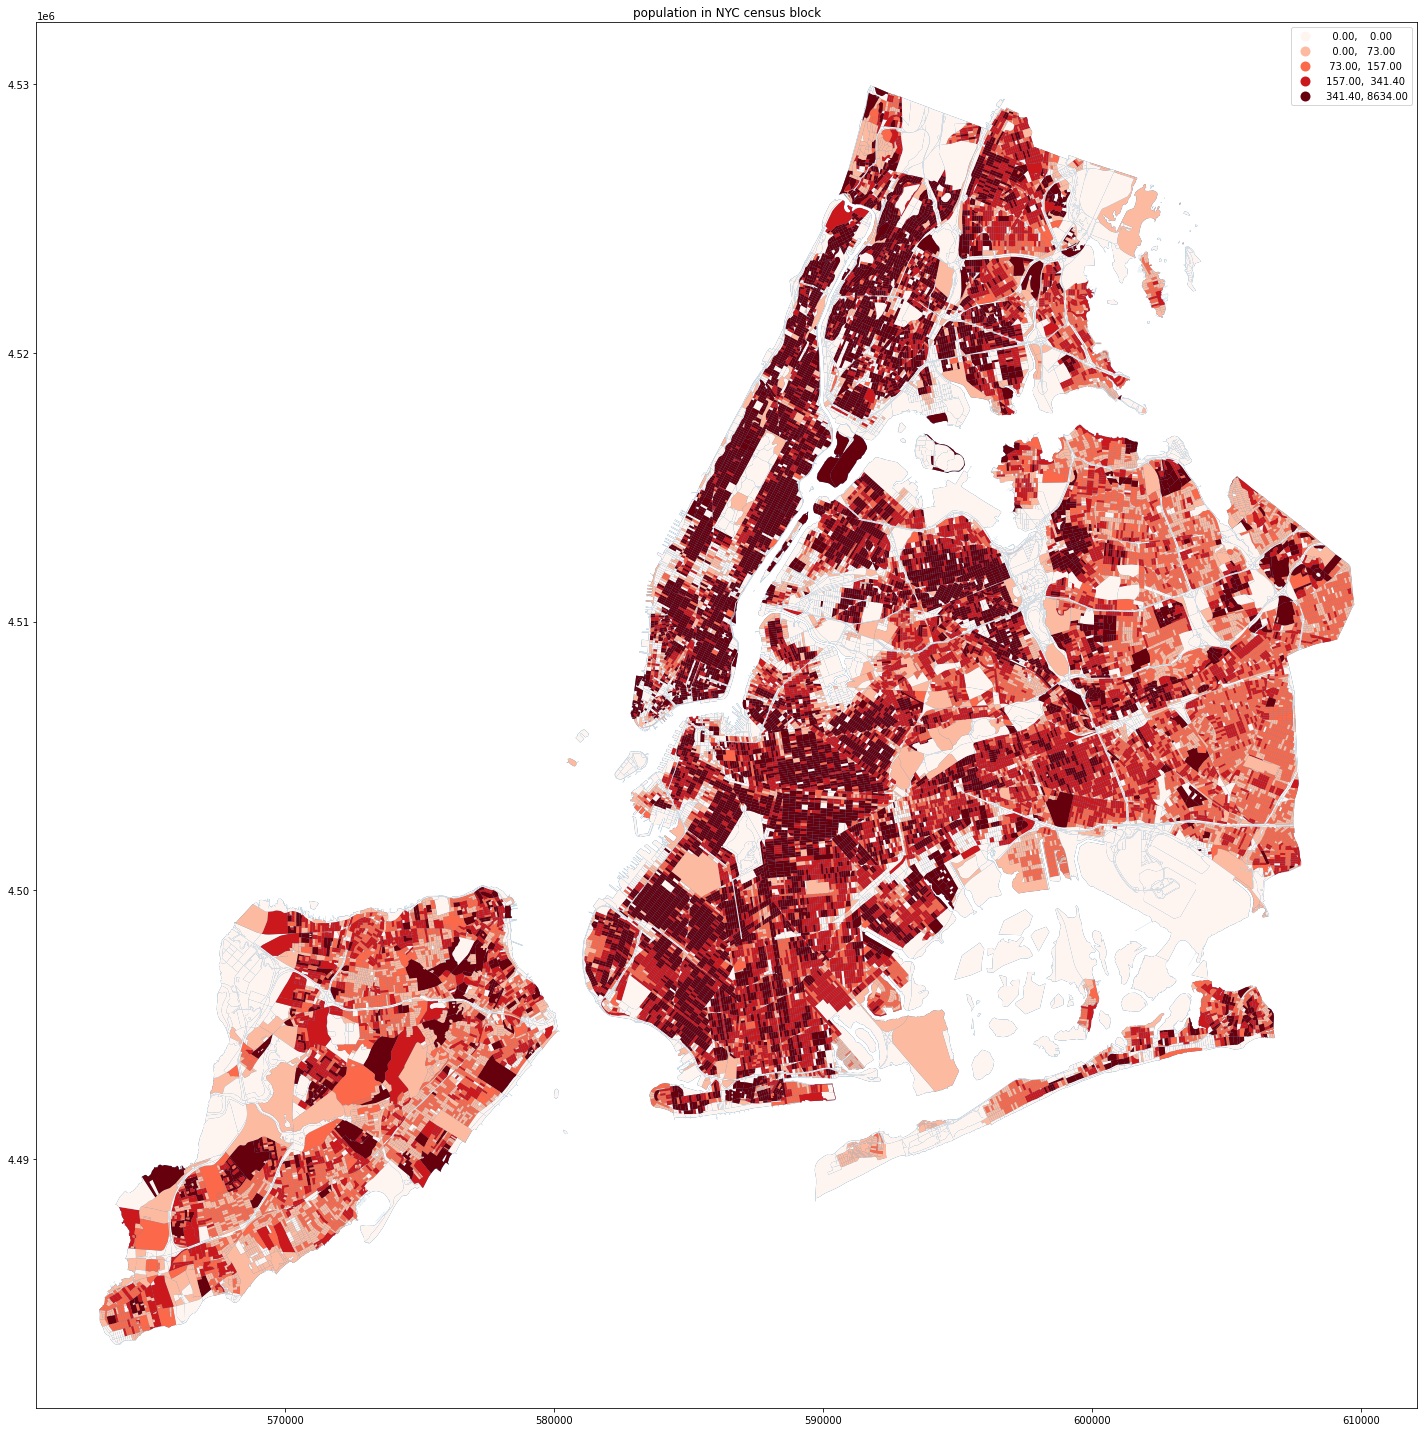

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

nyc_census_blocks.plot (ax = ax)

#plot points with pop info
nyc_census_blocks.plot(ax=ax, column ='POPN_TOTAL',cmap= 'Reds', markersize=15,scheme ='quantiles', legend = True)

# add title
plt.title("population in NYC census block")

# remove white space around figure
plt.tight_layout()
# shows low population census

In [ ]:
# Step 4: Check the count of census blocks per health care disctrict

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

In [ ]:
# Step 5: Dissolve (=combine) census block polygon geometries for each health care district, name the new geodatafram: districts

districts=join.dissolve(by='UHF_NEIGH', aggfunc='sum')

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

In [ ]:
districts.head()

,geometry,POPN_TOTAL,POPN_WHITE,POPN_BLACK,POPN_NATIV,POPN_ASIAN,POPN_OTHER,index_right,OBJECTID,UHFCODE,SHAPE_Leng,SHAPE_Area
UHF_NEIGH,,,,,,,,,,,,
Bayside - Little Neck,"MULTIPOLYGON (((604493.398 4510047.203, 604416...",82198,42556,2177,72,33459,3934,29120,30030,367640.0,6.389641e+07,1.952576e+11
Bedford Stuyvesant - Crown Heights,"POLYGON ((591374.904 4500950.287, 591366.839 4...",282757,37502,215982,1407,5282,22584,7710,8481,156513.0,5.374719e+07,1.281605e+11
Bensonhurst - Bay Ridge,"MULTIPOLYGON (((585606.603 4493052.686, 585599...",185731,124441,2554,503,43222,15011,11360,12070,148390.0,5.189351e+07,1.138831e+11
Borough Park,"MULTIPOLYGON (((584982.571 4496393.331, 584779...",283218,194180,9594,979,55423,23042,11596,12488,183752.0,5.638933e+07,1.533136e+11
Canarsie - Flatlands,"MULTIPOLYGON (((591404.261 4494862.288, 591406...",169596,45706,109494,519,5851,8026,13695,14608,189904.0,1.299406e+08,3.285700e+11


In [ ]:
districts.index

Index(['Bayside - Little Neck', 'Bedford Stuyvesant - Crown Heights',
       'Bensonhurst - Bay Ridge', 'Borough Park', 'Canarsie - Flatlands',
       'Central Harlem - Morningside Heights', 'Chelsea - Clinton',
       'Coney Island - Sheepshead Bay', 'Crotona - Tremont',
       'Downtown  - Heights - Slope', 'East Flatbush - Flatbush',
       'East Harlem', 'East New York', 'Flushing - Clearview',
       'Fordham - Bronx Park', 'Fresh Meadows', 'Gramercy Park -  Murray Hill',
       'Greenpoint', 'Greenwich Village - Soho', 'High Bridge - Morrisania',
       'Hunts Point - Mott Haven', 'Jamaica', 'Kingsbridge - Riverdale',
       'Long Island City - Astoria', 'Lower Manhattan', 'Northeast Bronx',
       'Pelham - Throgs Neck', 'Port  Richmond', 'Ridgewood - Forest Hills',
       'Rockaway', 'South Beach - Tottenville', 'Southeast Queens',
       'Southwest Queens', 'Stapleton - St. George', 'Sunset Park',
       'Union Square - Lower East Side', 'Upper East Side', 'Upper West Side',
 

In [ ]:
import mapclassify

In [ ]:
mapclassify.NaturalBreaks(y=districts['POPN_TOTAL'])

NaturalBreaks                 

       Interval          Count
------------------------------
[ 43701.00,  88083.00] |     7
( 88083.00, 134266.00] |     9
(134266.00, 209283.00] |    15
(209283.00, 287255.00] |    10
(287255.00, 453897.00] |     1

In [ ]:
classifier = mapclassify.NaturalBreaks(y=districts['POPN_TOTAL'])


In [ ]:
classifications = districts[['POPN_TOTAL']].apply(classifier)


In [ ]:
classifications.head()

,POPN_TOTAL
UHF_NEIGH,
Bayside - Little Neck,0
Bedford Stuyvesant - Crown Heights,3
Bensonhurst - Bay Ridge,2
Borough Park,3
Canarsie - Flatlands,2


In [ ]:
districts['nb_pop'] = districts[['POPN_TOTAL']].apply(classifier)

# Check the original values and classification
districts[['POPN_TOTAL', 'nb_pop']].head()

,POPN_TOTAL,nb_pop
UHF_NEIGH,,
Bayside - Little Neck,82198,0
Bedford Stuyvesant - Crown Heights,282757,3
Bensonhurst - Bay Ridge,185731,2
Borough Park,283218,3
Canarsie - Flatlands,169596,2


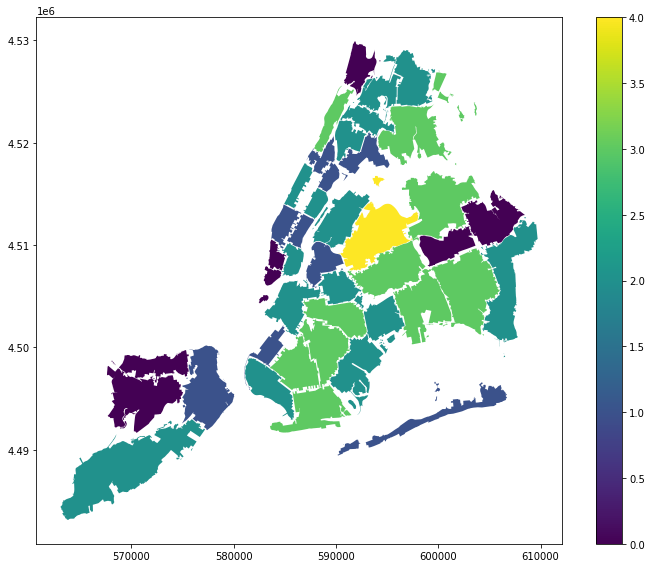

In [ ]:
# Plot
districts.plot(column="nb_pop", linewidth=0, legend=True, figsize=(10, 8))

# Use tight layout
plt.tight_layout()

In [ ]:
# Step 6: Plot districts using column='UHF_NEIGH'
import matplotlib.pyplot as plt
districts['nb_pop']=districts[['UGH_NEIGH']].
districts.plot(column = 'UHF_NEIGH' , cmap='YlOrRd', legend=True, figsize=(10,10)) 
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

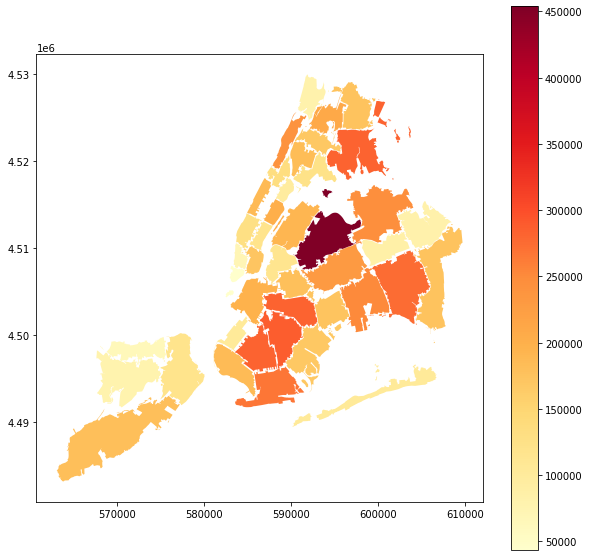

In [ ]:
# Step 6: Plot districts using column='POPN_TOTAL'
districts.plot(column = 'POPN_TOTAL' , cmap='YlOrRd', legend=True, figsize=(10,10)) # plots wrt the population in each neighborhood

# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

In [ ]:
# Step 7: Write healthDistricts into GeoJSON
# Output filepath
outfp = "../Data/nyc_shapefiles/assignment3.geojson"

# Use GeoJSON driver, replace None
districts.to_file(outfp, driver='GeoJSON')
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

# re_index and something becomes the column

## Problem 2: How can we classify the population in each health district wisely?

**Steps:**
1. Plot the histogram using the `population in each health district` column 
2. Define a natural breaks classifier add threshold values on top of the histogram as vertical lines (using k=6)
3. Define a quantiles classifier add threshold values on top of the histogram as vertical lines (using k=6)
4. Discuss which classifier is better and why?
5. Plot using the classifier that you think is better.
6. Report how many districts are in each class based on your classifier

Problem 2 there is a typo:
should be "# Step 1: Histogram for population in each health district"

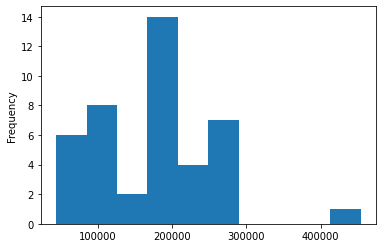

In [ ]:
# Step 1: Histogram for distances to subway stations
districts['POPN_TOTAL'].plot.hist(bins=10)
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

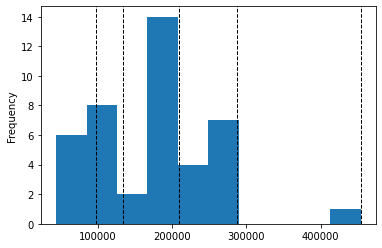

In [ ]:
# Step 2: Define a natural breaks classifier add threshold values on top of the histogram as vertical lines (using k=6)
import mapclassify
import matplotlib.pyplot as plt

# Define classifier, replace None
classifier =mapclassify.NaturalBreaks(y=districts['POPN_TOTAL']) 

# Plot histogram, replace None
districts['POPN_TOTAL'].plot.hist(bins=10)

# Add vertical lines for class breaks
for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed', linewidth=1)
    #plot historgram and break thresholds


# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

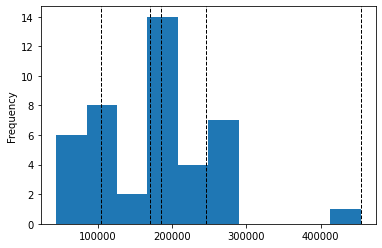

In [ ]:
# 3. Define a quantiles classifier add threshold values on top of the histogram as vertical lines 
# Define classifier, replace None
classifier =mapclassify.Quantiles(y=districts['POPN_TOTAL']) 

# Plot histogram, replace None
districts['POPN_TOTAL'].plot.hist(bins=10)

# Add vertical lines for class breaks
for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed', linewidth=1)
    #plot historgram and break thresholds
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

Step 4. Discuss which classifier is better and why?

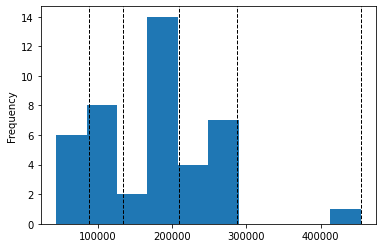

In [ ]:
# Step 5. Plot using the classifier that you think is better.

# Define classifier
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# Define classifier, replace None
classifier =mapclassify.NaturalBreaks(y=districts['POPN_TOTAL']) 

# Plot histogram, replace None
districts['POPN_TOTAL'].plot.hist(bins=10)

# Add vertical lines for class breaks
for value in classifier.bins:
    plt.axvline(value, color='k', linestyle='dashed', linewidth=1)
    #plot historgram and break thresholds

# Classify the data and assign the classification to a new column in 'districts'
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

In [ ]:
def custom_classifier(row, src_col1, src_col2, threshold1, threshold2, output_col):
    """Custom classirifer that can be applied on each row of a pandas dataframe (axis=1).
    
    This function classifies data based on values in two source columns and stores the output value in the output column.
    Output values is 1 if the value in src_col1 is LOWER than the threshold1 value AND the value in src_col2 is HIGHER than the threshold2 value. 
    In all other cases, output value is 0.
    
    Args:
        row: one row of data
        src_col1: source column name associated with threshold1
        src_col2: source column name associated with threshold2
        threshold1: upper threshold value for src_col1
        threshold2: lower threshold value for src_col2
        output_col: output column name

    Returns:
        updated row of data.
    """

    # If condition is true, assign 1 into output column
    print("value of src_col1 is {} and threshold1 is {} and crc_col2 {} and threshold2 {}".format(row[src_col1], threshold1, row[src_col2] ,threshold2 ))
    if row[src_col1] < threshold1 and row[src_col2] > threshold2:
        row[output_col] = 1
    
    # Else, assign 1 into output column
    else:
        row[output_col] = 0

    # Return the updated row
    return row

In [ ]:
# Plot the classification
districts["selected"] = None
#selected column is either 1 or 0 dependiong on the custom classifier

# Apply the function, replace None
districts = districts.apply(custom_classifier, src_col1='POPN_TOTAL', src_col2='POPN_TOTAL',
                            threshold1=400000,
                            threshold2=200000,
                            output_col='selected',
                            axis=1)

# See the first rows
districts.head(50)
# REPLACE THE ERROR BELOW WITH YOUR OWN CODE
# raise NotImplementedError()

value of src_col1 is 82198 and threshold1 is 400000 and crc_col2 82198 and threshold2 200000
value of src_col1 is 282757 and threshold1 is 400000 and crc_col2 282757 and threshold2 200000
value of src_col1 is 185731 and threshold1 is 400000 and crc_col2 185731 and threshold2 200000
value of src_col1 is 283218 and threshold1 is 400000 and crc_col2 283218 and threshold2 200000
value of src_col1 is 169596 and threshold1 is 400000 and crc_col2 169596 and threshold2 200000
value of src_col1 is 134266 and threshold1 is 400000 and crc_col2 134266 and threshold2 200000
value of src_col1 is 128725 and threshold1 is 400000 and crc_col2 128725 and threshold2 200000
value of src_col1 is 266696 and threshold1 is 400000 and crc_col2 266696 and threshold2 200000
value of src_col1 is 169879 and threshold1 is 400000 and crc_col2 169879 and threshold2 200000
value of src_col1 is 198140 and threshold1 is 400000 and crc_col2 198140 and threshold2 200000
value of src_col1 is 287255 and threshold1 is 400000

,geometry,POPN_TOTAL,POPN_WHITE,POPN_BLACK,POPN_NATIV,POPN_ASIAN,POPN_OTHER,index_right,OBJECTID,UHFCODE,SHAPE_Leng,SHAPE_Area,nb_pop,selected
UHF_NEIGH,,,,,,,,,,,,,,
Bayside - Little Neck,"MULTIPOLYGON (((604493.398 4510047.203, 604416...",82198,42556,2177,72,33459,3934,29120,30030,367640.0,6.389641e+07,1.952576e+11,0,0
Bedford Stuyvesant - Crown Heights,"POLYGON ((591374.904 4500950.287, 591366.839 4...",282757,37502,215982,1407,5282,22584,7710,8481,156513.0,5.374719e+07,1.281605e+11,3,1
Bensonhurst - Bay Ridge,"MULTIPOLYGON (((585606.603 4493052.686, 585599...",185731,124441,2554,503,43222,15011,11360,12070,148390.0,5.189351e+07,1.138831e+11,2,0
Borough Park,"MULTIPOLYGON (((584982.571 4496393.331, 584779...",283218,194180,9594,979,55423,23042,11596,12488,183752.0,5.638933e+07,1.533136e+11,3,1
Canarsie - Flatlands,"MULTIPOLYGON (((591404.261 4494862.288, 591406...",169596,45706,109494,519,5851,8026,13695,14608,189904.0,1.299406e+08,3.285700e+11,2,0
Central Harlem - Morningside Heights,"MULTIPOLYGON (((587896.645 4517166.567, 587900...",134266,25214,83096,1047,5247,19662,6020,6321,90902.0,1.531833e+07,1.848026e+10,1,0
Chelsea - Clinton,"MULTIPOLYGON (((584476.590 4509382.255, 584361...",128725,90419,8863,400,18388,10655,8616,8975,109854.0,3.145035e+07,2.851663e+10,1,0
Coney Island - Sheepshead Bay,"MULTIPOLYGON (((586054.013 4492942.019, 586048...",266696,186227,20070,876,40787,18736,19771,20934,244230.0,1.184741e+08,2.661304e+11,3,1
Crotona - Tremont,"MULTIPOLYGON (((594486.279 4521460.035, 594470...",169879,35130,63141,2925,2523,66160,2710,3252,56910.0,3.613844e+07,5.793863e+10,2,0


In [ ]:
# Step 6. Report how many districts are in each class

districts['selected'].value_counts()

0    30
1    12
Name: selected, dtype: int64

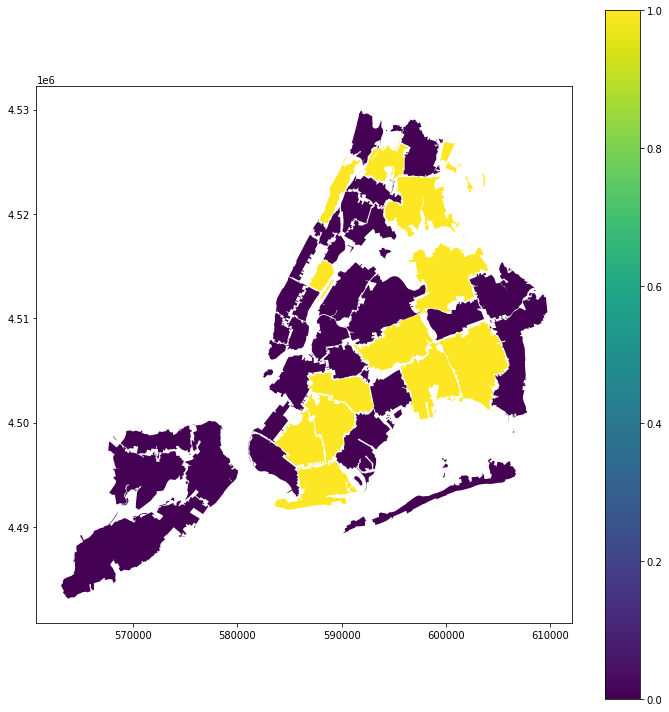

In [ ]:
# Plot
districts.plot(column="selected", linewidth=0, figsize=(10,10), legend=True)

# Use tight layor
plt.tight_layout()